In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize, curve_fit
import astropy.units as u
import astropy.constants as const
import math
import statistics
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.cm
import scipy.signal as signal
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import (ListedColormap, LinearSegmentedColormap)

In [28]:
# Errores a considerar

err_medicion = 15 * u.arcsec

err_ancho_franja_Hg = 5 * u.arcmin
err_ancho_franja_H = 59 * u.arcmin

## Marco teórico

La ecuación para una red de difracción, en una situación en que la luz incide normal sobre la red, está dada por:

$$mλ = d ⋅ \sin(\theta) \tag{1}$$

- $m$ = Orden del espectro observado
- $d$ = Constante de separación de la red
- $θ$ = Ángulo de difracción medido con respecto a la normal de la red

La ecuación que relaciona las líneas conocidas del espectro del hidrógeno está dada por:

$$\frac{1}{\lambda} = R_{H}\left(\frac{1}{4}-\frac{1}{n^2} \right) \tag{2} \\\\$$

$$n = 3,4,5,...$$

- $λ$ = Longitud de onda de la línea espectral
- $R_{H}$ = Constante de Rydberg
- $n$ = entero que corresponde al número de orden de cada línea espectral **en la serie de Balmer** (no es lo mismo que el orden del espectro)

### Marco teórico para combinación de errores

Si $f = f(x, y, z, ...)$ y $\delta x$ es el error en $x$, entonces el error en $f$ está dado por:

$$(\delta f)^{2}=\left(\frac{\partial f}{\partial x}\delta x\right)^{2} + \left(\frac{\partial f}{\partial y}\delta y\right)^{2} + ...$$

## Parte 1: Determinación de la constante de la red de difracción utilizando las líneas del espectro de Mercurio



In [67]:
# Ordenamos los datos en un DataFrame para trabajar con ellos

def calcular_dif_angulos(angulos: list, ordenes: list):
    # Función que calcula la diferencia de un ángulo medido respecto al orden cero
    diferencia_angulos = list()
    
    for i in range(len(angulos)):
      dif_angulo = angulos[i] - angulos[0]
      if ordenes[i] == 1:
        dif_angulo += 360 * u.deg
      diferencia_angulos.append(dif_angulo)
    
    return diferencia_angulos

angulos_medidos_Hg = [339 * u.deg + 10 * u.arcmin,
                      2 * u.deg + 40 * u.arcmin,
                      9 * u.deg + 7 * u.arcmin,
                      11 * u.deg + 3 * u.arcmin,
                      316 * u.deg + 1 * u.arcmin,
                      309 * u.deg + 45 * u.arcmin,
                      307 * u.deg + 51 * u.arcmin]

colores_lineas_Hg = ['Blanco', 'Violeta', 'Verde', 'Naranjo',
                     'Violeta', 'Verde', 'Naranjo']

long_ondas_Hg = [None, 405.5 * u.nm, 546.1 * u.nm, 579.1 *u.nm,
                 405.5 * u.nm, 546.1 * u.nm, 579.1 *u.nm]

ordenes_lineas_Hg = [0, 1, 1, 1,
                     -1, -1, -1]

diferencia_angulos_Hg = calcular_dif_angulos(angulos_medidos_Hg, ordenes_lineas_Hg)

errores_ancho_Hg = [err_ancho_franja_Hg,
                    err_ancho_franja_Hg,
                    err_ancho_franja_Hg,
                    err_ancho_franja_Hg,
                    err_ancho_franja_Hg,
                    err_ancho_franja_Hg,
                    err_ancho_franja_Hg]
errores_medicion_Hg = [err_medicion,
                       err_medicion,
                       err_medicion,
                       err_medicion,
                       err_medicion,
                       err_medicion,
                       err_medicion]

err_total_Hg = list()
for i in range(len(errores_ancho_Hg)):
  error = errores_ancho_Hg[i] + errores_medicion_Hg[i]
  err_total_Hg.append(error.to(u.deg))


dict_datos_Hg = {
    "Ángulos medidos": angulos_medidos_Hg,
    "Diferencia respecto al 0": diferencia_angulos_Hg,
    "Orden": ordenes_lineas_Hg,
    "Color de línea": colores_lineas_Hg,
    "Longitud de onda asociada": long_ondas_Hg,
    "Error de ancho de línea (±)": errores_ancho_Hg,
    "Error de medición (±)": errores_medicion_Hg,
    "Error total (±)": err_total_Hg
}


datos_Hg = pd.DataFrame(dict_datos_Hg)
datos_Hg


,Ángulos medidos,Diferencia respecto al 0,Orden,Color de línea,Longitud de onda asociada,Error de ancho de línea (±),Error de medición (±),Error total (±)
0,339.1666666666667 deg,0.0 deg,0,Blanco,None,5.0 arcmin,15.0 arcsec,0.0875 deg
1,2.6666666666666665 deg,23.5 deg,1,Violeta,405.5 nm,5.0 arcmin,15.0 arcsec,0.0875 deg
2,9.116666666666667 deg,29.94999999999999 deg,1,Verde,546.1 nm,5.0 arcmin,15.0 arcsec,0.0875 deg
3,11.05 deg,31.883333333333326 deg,1,Naranjo,579.1 nm,5.0 arcmin,15.0 arcsec,0.0875 deg
4,316.01666666666665 deg,-23.150000000000034 deg,-1,Violeta,405.5 nm,5.0 arcmin,15.0 arcsec,0.0875 deg
5,309.75 deg,-29.416666666666686 deg,-1,Verde,546.1 nm,5.0 arcmin,15.0 arcsec,0.0875 deg
6,307.85 deg,-31.316666666666663 deg,-1,Naranjo,579.1 nm,5.0 arcmin,15.0 arcsec,0.0875 deg


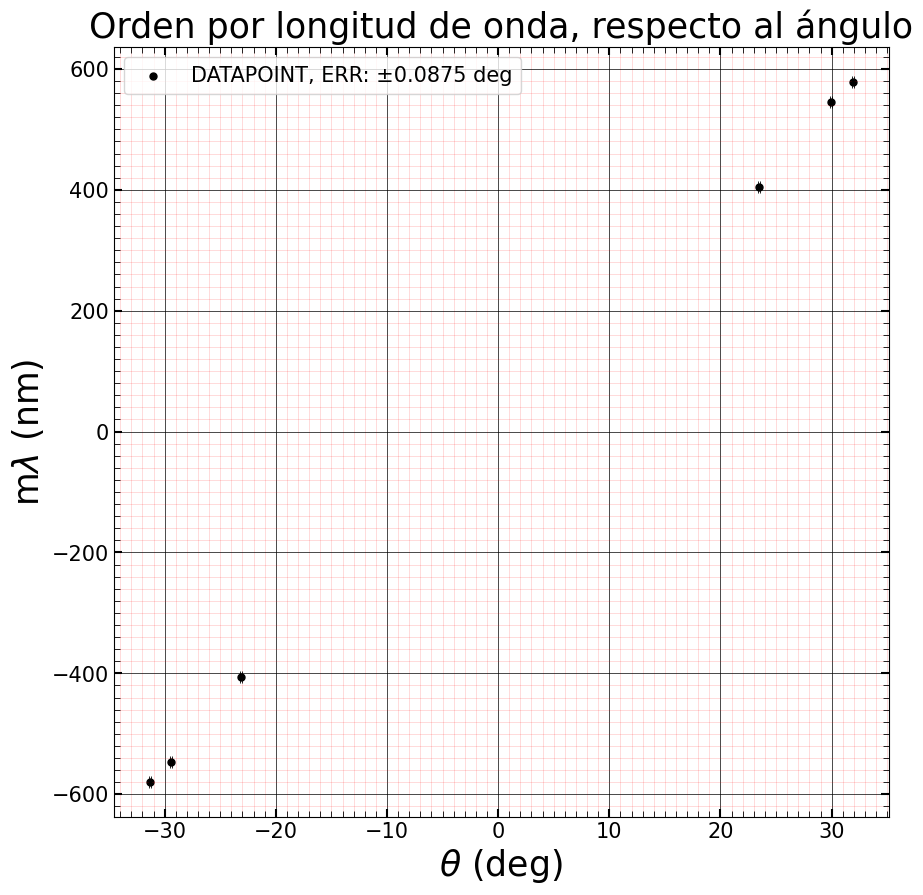

In [30]:
# Graficamos cómo cambia m * lambda con distintas diferencias de ángulo

orden_por_lambda = list()
diferencias_Hg = list()
diferencias_Hg_sin = list()
errorbar_Hg = list()

for i in datos_Hg["Orden"][1:] * datos_Hg["Longitud de onda asociada"][1:]:
  orden_por_lambda.append(i.value)
for i in datos_Hg['Diferencia respecto al 0'][1:]:
  diferencias_Hg.append(i.value)
  diferencias_Hg_sin.append(math.sin(math.radians(i.value)))
for i in datos_Hg["Error total (±)"][1:]:
  errorbar_Hg.append(i.value)

fig, ax1 = plt.subplots(figsize=(10, 10))

ax1.errorbar(diferencias_Hg, orden_por_lambda, xerr = errorbar_Hg, fmt = '.', markersize = '1', ecolor = 'Black', color = 'Black',capsize=4, capthick=0.6 )

ax1.scatter(diferencias_Hg, orden_por_lambda, marker=".", s=100, c="black", label='DATAPOINT, ERR: ±{} deg'.format(errorbar_Hg[1]))
ax1.set_title(r'Orden por longitud de onda, respecto al ángulo', fontsize=25)
ax1.set_ylabel(r'm$\lambda$ (nm)', fontsize=25)
ax1.set_xlabel(r'$\theta$ (deg)', fontsize=25)


ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)

ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_minor_locator(MultipleLocator(20))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax1.grid(True, which='both')
ax1.legend(fontsize=15)


In [31]:
# Definimos una función para estimar la constante de separación de red,
# en base a la ecuación (1). Por ahora, para probar, lo haremos sin
# considerar los errores

def constante_separacion_red(sin_angulo, constante_separacion):
  return sin_angulo * constante_separacion

In [63]:
# Hacemos un ajuste para d, utilizando curve_fit

popt_separacion_red, pcov_separacion_red = curve_fit(constante_separacion_red, diferencias_Hg_sin, orden_por_lambda, sigma=errorbar_Hg)

# La forma para calcular el error del ajuste aparece en la documentación de la función curve_fit() en scipy
perr_separacion_red = np.sqrt(np.diag(pcov_separacion_red[0]))[0][0]

print(float(popt_separacion_red[0]))
print("error: {}".format(perr_separacion_red))

1085.4709484069288
error: 15.564995653913568


In [33]:
sep_angulos_Hg_linspace = np.linspace(-32, 32, 100)
sep_angulos_Hg_linspace_sin = [math.sin(math.radians(angulo)) for angulo in sep_angulos_Hg_linspace]

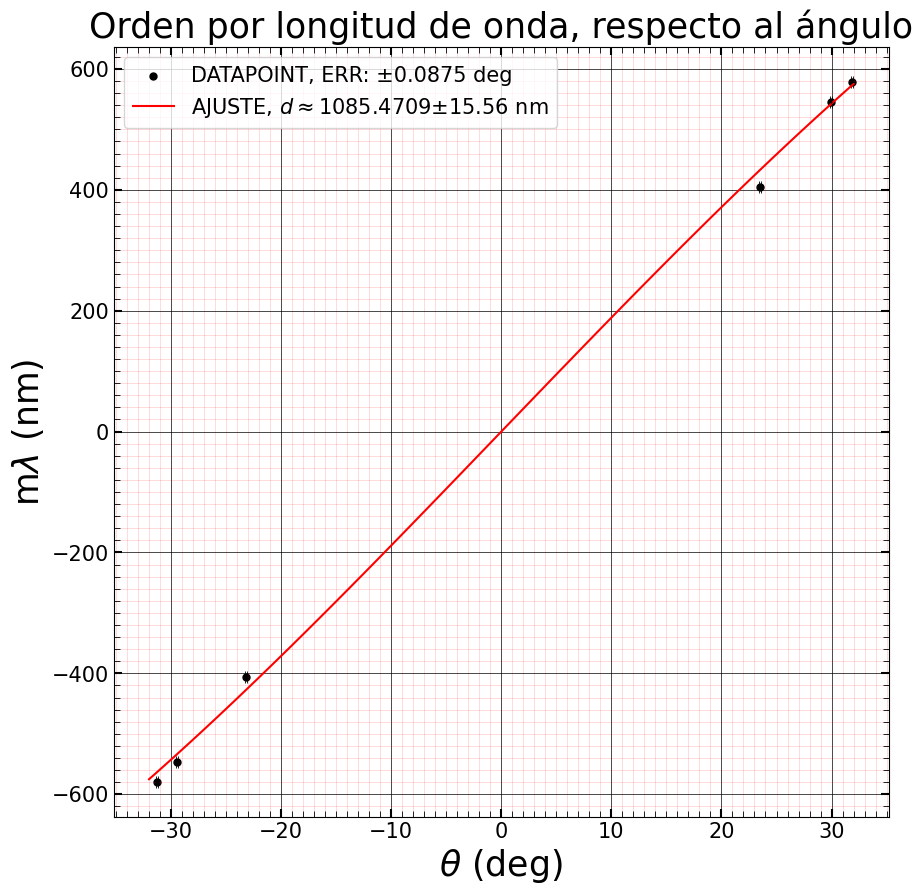

In [65]:
# Graficamos el ajuste para el cambio de m * lambda

fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.errorbar(diferencias_Hg, orden_por_lambda, xerr = errorbar_Hg, fmt = '.', markersize = '1', ecolor = 'Black', color = 'Black',capsize=4, capthick=0.6 )

ax1.scatter(diferencias_Hg, orden_por_lambda, marker=".", s=100, c="black", label='DATAPOINT, ERR: ±{} deg'.format(errorbar_Hg[1]))
ax1.plot(sep_angulos_Hg_linspace, constante_separacion_red(pd.DataFrame(sep_angulos_Hg_linspace_sin), float(popt_separacion_red[0])), c="red",
         label=r'AJUSTE, $d \approx {} ± {}$ nm'.format(round(popt_separacion_red[0], 4), round(perr_separacion_red, 2)))
ax1.set_title(r'Orden por longitud de onda, respecto al ángulo', fontsize=25)
ax1.set_ylabel(r'm$\lambda$ (nm)', fontsize=25)
ax1.set_xlabel(r'$\theta$ (deg)', fontsize=25)

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)

ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_minor_locator(MultipleLocator(20))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax1.grid(True, which='both')
ax1.legend(fontsize=15)

## Parte 2: Determinación de la Constante de Rydberg utilizando el espectro visible del Hidrógeno

In [71]:
angulos_medidos_H = [338 * u.deg + 3 * u.arcmin,
                     5 * u.deg + 10 * u.arcmin,
                     16 * u.deg + 4 * u.arcmin,
                     313 * u.deg + 3 * u.arcmin,
                     302 * u.deg + 1 * u.arcmin]

colores_lineas_H = ['Hidrógeno', 'Verde Agua', 'Rojo',
                    'Verde Agua', 'Rojo']

ordenes_lineas_H = [0, 1, 1,
                    -1, -1]

errores_ancho_H = [err_ancho_franja_H,
                   err_ancho_franja_H,
                   err_ancho_franja_H,
                   err_ancho_franja_H,
                   err_ancho_franja_H]
errores_medicion_H = [err_medicion,
                       err_medicion,
                       err_medicion,
                       err_medicion,
                       err_medicion]

balmer_n_H = [0, 4, 3, 4, 3]

diferencia_angulos_H = calcular_dif_angulos(angulos_medidos_H, ordenes_lineas_H)

err_total_H = list()
for i in range(len(errores_ancho_H)):
  error = errores_ancho_H[i] + errores_medicion_H[i]
  err_total_H.append(error.to(u.deg))

dict_datos_H = {
    "Ángulos medidos": angulos_medidos_H,
    "Diferencia respecto al 0": diferencia_angulos_H,
    "Orden": ordenes_lineas_H,
    "Color de línea": colores_lineas_H,
    "n (Orden en la serie de Balmer)": balmer_n_H,
    "Error de ancho de línea (±)": errores_ancho_H,
    "Error de medición (±)": errores_medicion_H,
    "Error total (±)": err_total_H
}


datos_long_onda_H = pd.DataFrame(dict_datos_H)
datos_long_onda_H

,Ángulos medidos,Diferencia respecto al 0,Orden,Color de línea,n (Orden en la serie de Balmer),Error de ancho de línea (±),Error de medición (±),Error total (±)
0,338.05 deg,0.0 deg,0,Hidrógeno,0,59.0 arcmin,15.0 arcsec,0.9874999999999999 deg
1,5.166666666666667 deg,27.116666666666674 deg,1,Verde Agua,4,59.0 arcmin,15.0 arcsec,0.9874999999999999 deg
2,16.066666666666666 deg,38.01666666666665 deg,1,Rojo,3,59.0 arcmin,15.0 arcsec,0.9874999999999999 deg
3,313.05 deg,-25.0 deg,-1,Verde Agua,4,59.0 arcmin,15.0 arcsec,0.9874999999999999 deg
4,302.01666666666665 deg,-36.03333333333336 deg,-1,Rojo,3,59.0 arcmin,15.0 arcsec,0.9874999999999999 deg


El orden en la serie de Balmer de las líneas registradas fue obtenido comparando el color de estas líneas con las longitudes de onda y los valores de $n$ presentados en el libro "Sears and Zemansky's University Physics with Modern Physics, 12th ed. (2008)" p. 1315. ISBN-13: 978-0-321-50121-9




Con las ecuaciones (1) y (2) podemos obtener una ecuación que nos entregue la constante de Rydberg para el átomo de Hidrógeno:

$$mλ = d ⋅ \sin(\theta) \tag{1}$$

$$⇒ \hspace{3mm} λ = \frac{d ⋅ \sin(\theta)}{m}$$

$$\frac{1}{\lambda} = R_{H}\left(\frac{1}{4}-\frac{1}{n^2} \right) \tag{2}$$

$$\frac{m}{d\cdot \sin(\theta)} =  R_{H}\left(\frac{1}{4}-\frac{1}{n^{2}}\right)$$

Siendo $d$ la constante de red encontrada anteriormente.

In [110]:
def m_d_sintheta(m, d, theta):
  return m / (d * math.sin(math.radians(theta)))

# Propagación de errores para m_d_sintheta
def err_m_d_sintheta(m, d, theta, d_err, theta_err):
  f_err_d = ((- m) / (d ** 2) * math.sin(math.radians(theta))) * d_err
  f_err_theta = ((m * math.cos(math.radians(theta))) / ((d * (math.cos(math.radians(theta))) ** 2) - d)) * theta_err
  return np.sqrt(f_err_d ** 2 + f_err_theta ** 2)

def rydberg_n_squared(n):
  return (1 / 4) - (1 / (n ** 2))

dif_angulos_H = [angulo.value for angulo in datos_long_onda_H["Diferencia respecto al 0"][1:]]
err_angulos_H = [error.value for error in datos_long_onda_H["Error total (±)"][1:]]
list_m_d_sintheta = list()
list_n_squared = list()
list_mdsintheta_err = list()

for i in range(len(dif_angulos_H)):
  aux_mds = m_d_sintheta(datos_long_onda_H["Orden"][1:][i + 1], popt_separacion_red[0], dif_angulos_H[i])
  aux_nsq = rydberg_n_squared(datos_long_onda_H["n (Orden en la serie de Balmer)"][1:][i + 1])
  aux_err_mds = err_m_d_sintheta(datos_long_onda_H["Orden"][1:][i + 1], popt_separacion_red[0], dif_angulos_H[i], perr_separacion_red, err_angulos_H[i])
  list_m_d_sintheta.append(aux_mds)
  list_n_squared.append(aux_nsq)
  list_mdsintheta_err.append(aux_err_mds)

list_m_d_sintheta
list_n_squared
list_mdsintheta_err

[0.0038975583417805745,
 0.0018895095286692923,
 0.0046163466155770124,
 0.002126000187544625]

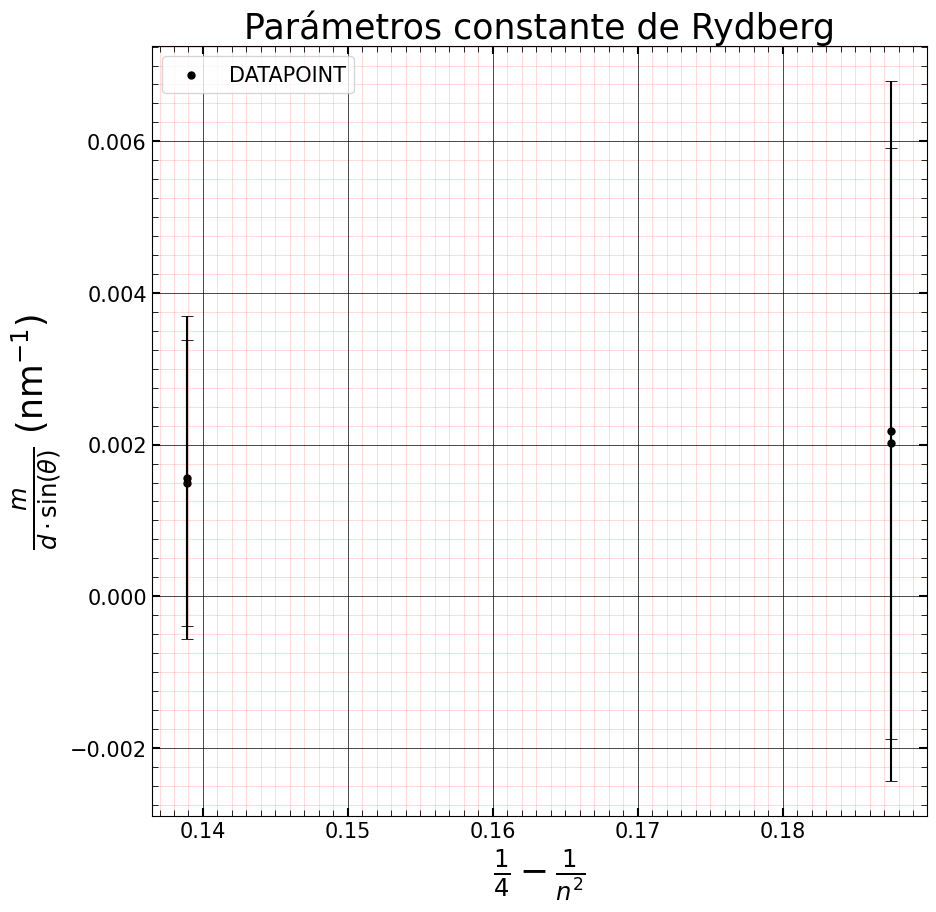

In [143]:
fig, ax1 = plt.subplots(figsize=(10, 10))

ax1.errorbar(list_n_squared, list_m_d_sintheta, yerr = list_mdsintheta_err, fmt = '.', markersize = '1', ecolor = 'Black', color = 'Black',capsize=4, capthick=0.6 )
ax1.scatter(list_n_squared, list_m_d_sintheta, marker=".", s=100, c="black", label='DATAPOINT')
ax1.set_title(r'Parámetros constante de Rydberg', fontsize=25)
ax1.set_ylabel(r'$\frac{m}{d\cdot \sin(\theta)}$ (nm$^{-1}$)', fontsize=25)
ax1.set_xlabel(r'$\frac{1}{4} - \frac{1}{n^{2}}$', fontsize=25)


ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)

ax1.xaxis.set_minor_locator(MultipleLocator(0.001))
ax1.yaxis.set_minor_locator(MultipleLocator(0.00025))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax1.grid(True, which='both')
ax1.legend(fontsize=15)

In [114]:
def constante_rydberg(n_squared, constante_rydberg):
  return n_squared * constante_rydberg

In [121]:
popt_rydberg, pcov_rydberg = curve_fit(constante_rydberg, list_n_squared, list_m_d_sintheta, sigma=list_mdsintheta_err)

perr_rydberg = np.sqrt(np.diag(pcov_rydberg[0]))[0][0] * u.nm ** -1

print((float(popt_rydberg[0]) * u.nm ** -1).to(u.m ** -1))
print("error: {}".format(perr_rydberg.to(u.m**-1)))

11033480.57123117 1 / m
error: 181973.84626075934 1 / m


In [130]:
nsq_linspace = np.linspace(0.135, 0.19, 100)

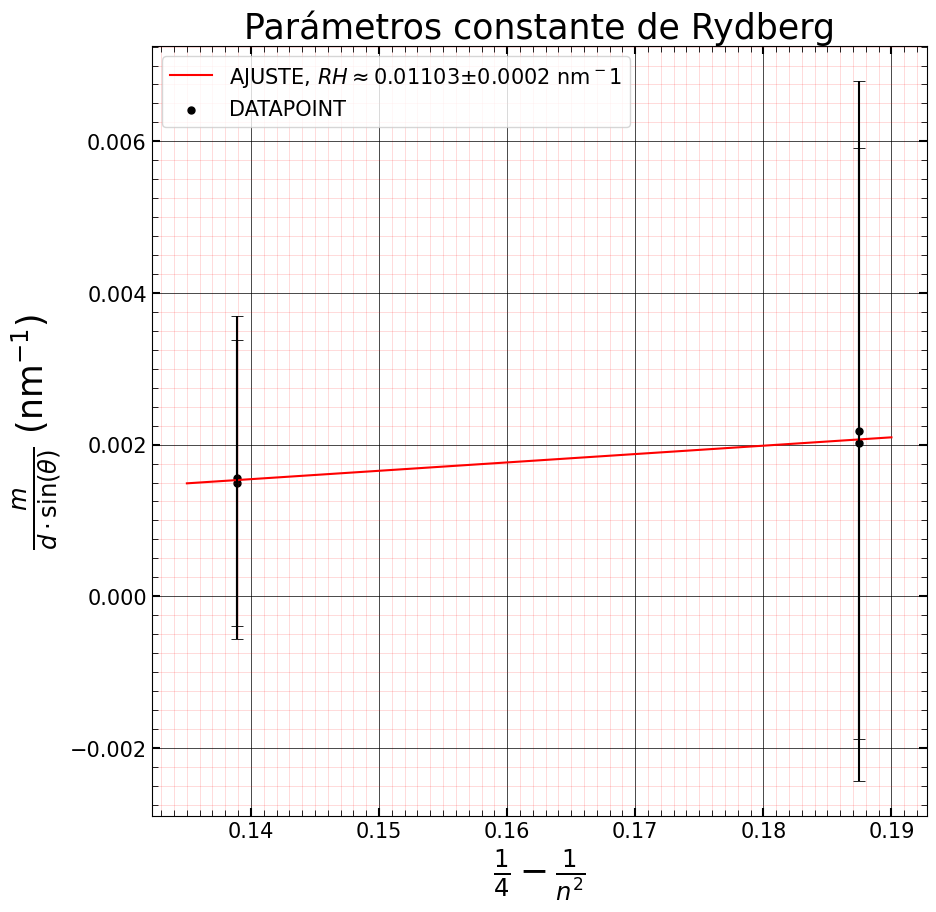

In [146]:
fig, ax1 = plt.subplots(figsize=(10, 10))

ax1.plot(nsq_linspace, constante_rydberg(pd.DataFrame(nsq_linspace), float(popt_rydberg[0])), c="red",
         label=r'AJUSTE, $RH \approx {} ± {}$ nm$^-1$'.format(round(popt_rydberg[0], 5), round(perr_rydberg.value, 4)))
ax1.errorbar(list_n_squared, list_m_d_sintheta, yerr = list_mdsintheta_err, fmt = '.', markersize = '1', ecolor = 'Black', color = 'Black',capsize=4, capthick=0.6 )
ax1.scatter(list_n_squared, list_m_d_sintheta, marker=".", s=100, c="black", label='DATAPOINT')
ax1.set_title(r'Parámetros constante de Rydberg', fontsize=25)
ax1.set_ylabel(r'$\frac{m}{d\cdot \sin(\theta)}$ (nm$^{-1}$)', fontsize=25)
ax1.set_xlabel(r'$\frac{1}{4} - \frac{1}{n^{2}}$', fontsize=25)


ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)

ax1.xaxis.set_minor_locator(MultipleLocator(0.001))
ax1.yaxis.set_minor_locator(MultipleLocator(0.00025))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax1.grid(True, which='both')
ax1.legend(fontsize=15)

## Resumen

In [169]:
string_const_sep = f"Constante de separación de red encontrada: d = {round(float(popt_separacion_red[0]), 3)} ± {round(perr_separacion_red, 3)} nm \n\n"
string_const_ryd = f"Constante de Rydberg encontrada: Rh = {float(popt_rydberg[0])} ± {round(perr_rydberg.value, 7)} 1/nm \n"
string_const_ryd_si = f"Constante de Rydberg encontrada (en unidades SI): Rh = {round((float(popt_rydberg[0]) * u.nm**-1).to(u.m ** -1).value, 3)} ± {round(perr_rydberg.to(u.m ** -1).value, 3)} 1/m \n"

porc_err = (perr_rydberg.value * 100) / float(popt_rydberg[0])

string_porc_err = f"Porcentaje de error del valor obtenido: ± {round(porc_err, 4)} %\n"


def err_porcentual_teo_exp_rydberg(rydberg_exp, err_rydberg_exp):
  dif = np.abs(rydberg_exp - const.Ryd.to(u.nm ** -1).value)
  porc_dif = (100 * dif) / const.Ryd.to(u.nm ** -1).value
  err_porc_dif = (100 / const.Ryd.to(u.nm ** -1).value) * err_rydberg_exp
  return porc_dif, err_porc_dif

diferencia_ryd_teo, err_diferencia_ryd_tep = err_porcentual_teo_exp_rydberg(float(popt_rydberg[0]), perr_rydberg.value)

string_porc_dif = f"\nDiferencia porcentual entre la constante de Rydberg encontrada y la teórica (con respecto a la teórica): {round(diferencia_ryd_teo, 3)} ± {round(err_diferencia_ryd_tep, 3)} %"
print(string_const_sep, string_const_ryd, string_const_ryd_si, string_porc_err, string_porc_dif)

Constante de separación de red encontrada: d = 1085.471 ± 15.565 nm 

 Constante de Rydberg encontrada: Rh = 0.011033480571231172 ± 0.000182 1/nm 
 Constante de Rydberg encontrada (en unidades SI): Rh = 11033480.571 ± 181973.846 1/m 
 Porcentaje de error del valor obtenido: ± 1.6493 %
 
Diferencia porcentual entre la constante de Rydberg encontrada y la teórica (con respecto a la teórica): 0.544 ± 1.658 %
